# Machine Learning for Time Series Data in Python
This chapter is an introduction to the basics of machine learning, time series data, and the intersection between the two. This is the Summary of lecture "Machine Learning for Time Series Data in Python", via datacamp.

 - ### Predicting Time Series Data - Chapter 3



In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from functools import partial

#### 1. Predicting data over time

In the third chapter we'll shift our focus from classification to regression. Regression has several features and caveats that are unique to timeseries data. We'll begin by visualizing and predicting timeseries data. Then, we'll cover the basics of cleaning the data, and finally, we'll begin extracting features that we can use in our models.


- Classification vs. Regression
The biggest difference between regression and classification is that regression models predict continuous outputs whereas classification models predict categorical outputs. In the context of timeseries, this means we can have more fine-grained predictions over time.


- Correlation and regression
Both Regression and correlation reflect the extent to which the values of two variables have a consistent relationship (either they both go down or up together, or they have an inverse relationship). However, regression results in a "model" of the data, while correlation is just a single statistic that describes the data. Regression models have more information about the data, while correlation is easier to calculate and interpret.


 -  Correlation between variables often changes over time
When running regression models with timeseries data, it's important to visualize how the data changes over time. You can either do this by plotting the whole timeseries at once, or by directly comparing two segments of time.


 -  Regression models with scikit-learn
Fitting regression models with scikit-learn works the same way as classifiers - the consistency in API is one of scikit-learn's greatest strengths. There are, however, a completely different subset of models that accomplish regression. We'll begin by focusing on LinearRegression, which is the simplest form of regression. Here we see how you can instantiate the model, fit, and predict on training data.


 -  Scoring regression models
Visualizing is useful, but not quantifiable. There are several options for scoring a regression model. The simplest is the correlation coefficient, whereas the most common is the coefficient of determination, or R squared.


 -  Coefficient of Determination ($R^2$)
The coefficient of determination can be summarized as the total amount of error in your model (the difference between predicted and actual values) divided by the total amount of error if you'd built a "dummy" model that simply predicted the output data's mean value at each timepoint. You subtract this ratio from "1", and the result is the coefficient of determination. It is bounded on top by "1", and can be infinitely low (since models can be infinitely bad).


 -  $R^2$ in scikit-learn
In scikit-learn, we can import the r2_score function which calculates the coefficient of determination. It takes the predicted output values first, and the "true" output values second, to calculate r-square.

#### Predicting data over time summary
- Correlation and regression
    - Regression is similar to calculating correlation, with some key differences
        - Regression: A process that results in a formal model of the data
        - Correlation: A statistic that describes the data. Less information than regression model
- Correlation between variables often changes over time
    - Time series often have patterns that change over time
    - Two timeseries that seem correlated at one moment may not remain so over time.
- Scoring regression models
    - Two most common methods:
        - Correlation ($r$)
        - Coefficient of Determination ($R^2$)
            - The value of $R^2$ is bounded on the top by 1, and can be infinitely low
            - Values closer to 1 mean the model does a better jot of predicting outputs \
       $1 - \frac{\text{error}(model)}{\text{variance}(testdata)}$

#### 1 A: Introducing the dataset
As mentioned in the video, you'll deal with stock market prices that fluctuate over time. In this exercise you've got historical prices from two tech companies (Ebay and Yahoo) in the DataFrame prices. You'll visualize the raw data for the two companies, then generate a scatter plot showing how the values for each company compare with one another. Finally, you'll add in a "time" dimension to your scatter plot so you can see how this relationship changes over time.

The data has been loaded into a DataFrame called prices.

In [4]:
prices = pd.read_csv('./dataset/tsa_prices.csv', index_col='date', parse_dates=True)
prices.head()

,EBAY,YHOO
date,,
2010-01-04,23.900000,17.100000
2010-01-05,23.650000,17.230000
2010-01-06,23.500000,17.170000
2010-01-07,23.229998,16.700001
2010-01-08,23.509999,16.700001


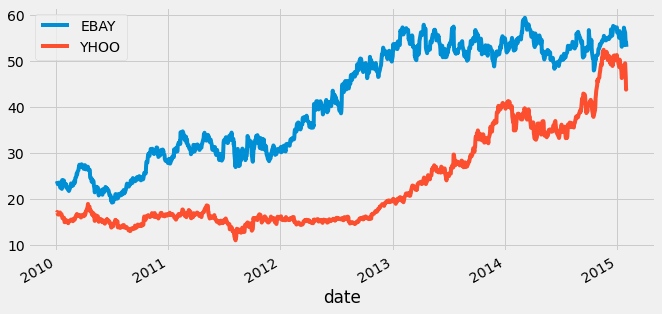

In [5]:
#Plot the data in prices. Pay attention to any irregularities you notice.
# Plot the raw values over time
prices.plot()
plt.show()

<AxesSubplot:xlabel='EBAY', ylabel='YHOO'>

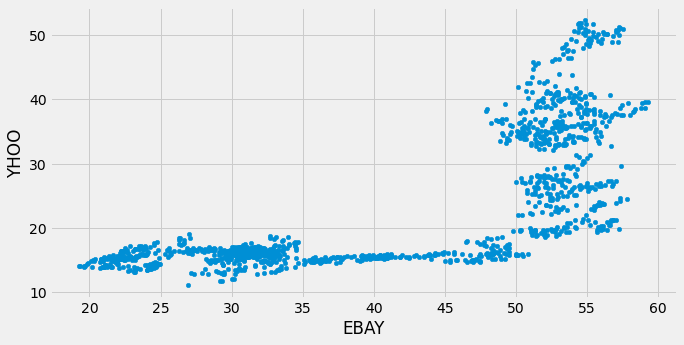

In [6]:
#Generate a scatter plot with the values of Ebay on the x-axis, and Yahoo on the y-axis. 
prices.plot.scatter('EBAY', 'YHOO')
#Look up the symbols for both companies from the column names of the DataFrame.


<AxesSubplot:xlabel='EBAY', ylabel='YHOO'>

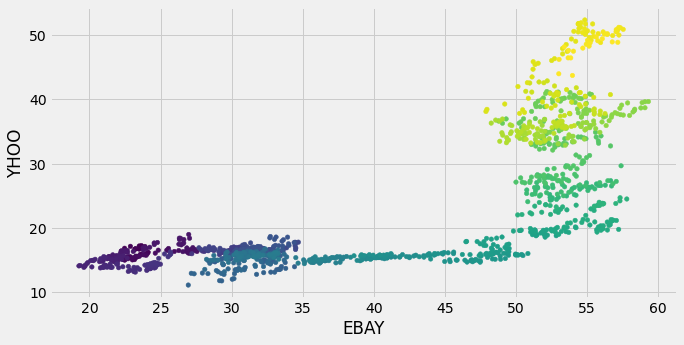

In [7]:
#Finally, encode time as the color of each datapoint in order 
   #to visualize how the relationship between these two variables changes.
prices.plot.scatter('EBAY', 'YHOO', c=prices.index, cmap=plt.cm.viridis, colorbar=False)    
    

 note: Correct! As you can see, these two time series seem somewhat related to each other, though its a complex relationship that changes over time.

#### 1 B: Fitting a simple regression model
Now we'll look at a larger number of companies. Recall that we have historical price values for many companies. Let's use data from several companies to predict the value of a test company. You'll attempt to predict the value of the Apple stock price using the values of NVidia, Ebay, and Yahoo. Each of these is stored as a column in the all_prices DataFrame. Below is a mapping from company name to column name:
```
ebay: "EBAY"
nvidia: "NVDA"
yahoo: "YHOO"
apple: "AAPL"
```
We'll use these columns to define the input/output arrays in our model.

In [8]:
all_prices = pd.read_csv('./dataset/all_prices.csv', index_col=0, parse_dates=True)
all_prices.head()

,AAPL,ABT,AIG,AMAT,ARNC,BAC,BSX,C,CHK,CMCSA,...,QCOM,RF,SBUX,T,V,VZ,WFC,XOM,XRX,YHOO
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,214.009998,54.459951,29.889999,14.30,16.650013,15.690000,9.01,3.40,28.090001,16.969999,...,46.939999,5.42,23.049999,28.580000,88.139999,33.279869,27.320000,69.150002,8.63,17.100000
2010-01-05,214.379993,54.019953,29.330000,14.19,16.130013,16.200001,9.04,3.53,28.970002,16.740000,...,48.070000,5.60,23.590000,28.440001,87.129997,33.339868,28.070000,69.419998,8.64,17.230000
2010-01-06,210.969995,54.319953,29.139999,14.16,16.970013,16.389999,9.16,3.64,28.650002,16.620001,...,47.599998,5.67,23.420000,27.610001,85.959999,31.919873,28.110001,70.019997,8.56,17.170000
2010-01-07,210.580000,54.769952,28.580000,14.01,16.610014,16.930000,9.09,3.65,28.720002,16.969999,...,48.980000,6.17,23.360001,27.299999,86.760002,31.729875,29.129999,69.800003,8.60,16.700001
2010-01-08,211.980005,55.049952,29.340000,14.55,17.020014,16.780001,9.00,3.59,28.910002,16.920000,...,49.470001,6.18,23.280001,27.100000,87.000000,31.749874,28.860001,69.519997,8.57,16.700001


In [11]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Create the X and y arrays by using the column names provided.
# The input values should be from the companies "ebay", "nvidia", and "yahoo"
# The output values should be from the company "apple"
X = all_prices[["EBAY", "NVDA", "YHOO"]]
y = all_prices[["AAPL"]]

# Use the data to train and score the model with cross-validation.
scores = cross_val_score(Ridge(), X, y, cv=3)
print(scores)

[-6.09050633 -0.3179172  -3.72957284]


note: Yes! As you can see, fitting a model with raw data doesn't give great results.

#### 1 C: Visualizing predicted values
When dealing with time series data, it's useful to visualize model predictions on top of the "actual" values that are used to test the model.

In this exercise, after splitting the data (stored in the variables X and y) into training and test sets, you'll build a model and then visualize the model's predictions on top of the testing data in order to estimate the model's performance.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Split the data (X and y) into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, shuffle=False, random_state=1)
# Use the training data to train the regression model.
model = Ridge()
model.fit(X_train, y_train)

# Then use the testing data to generate predictions for the model.
predictions = model.predict(X_test)
score = r2_score(y_test, predictions)
print(score)


-0.3380697256228926


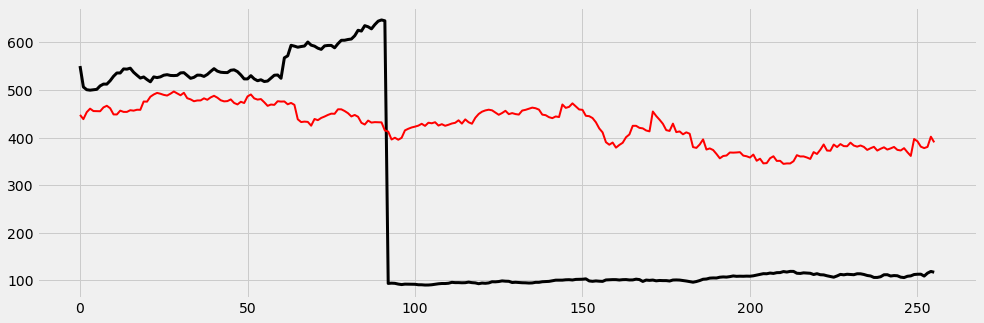

In [16]:
#Plot a time series of the predicted and "actual" values of the testing data.

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(range(len(y_test)), y_test, color='k', lw=3);
ax.plot(range(len(predictions)), predictions, color='r', lw=2);

note: Correct! Now you have an explanation for your poor score. The predictions clearly deviate from the true time series values.

#### 2:  Advanced time series prediction

 Interpolation: using time to fill in missing data
First, let's fill in the missing data using other datapoints we do have. We'll use a technique called interpolation, which uses the values on either end of a missing window of time to infer what's in-between.


 - Interpolation in Pandas
In this example, we'll first create a boolean mask that we'll use to mark where the missing values are. Next, we call the dot-interpolate method to fill in the missing values. We'll use the first argument to signal we want linear interpolation. Finally, we'll plot the interpolated values.


 -  Visualizing the interpolated data
You can see the results of interpolation in red. In this case, we used the "linear" argument so the interpolated values are a line between the start and stop point of the missing window. Other arguments to the dot-interpolate method will result in different behavior.


 -  Using a rolling window to transform data
Another common technique to clean data is transforming it so that it is more well-behaved. To do this, we'll use the same rolling window technique covered in Chapter 2.


 -  Transforming data to standardize variance
Using a rolling window, we'll calculate each timepoint's percent change over the mean of a window of previous timepoints. This standardizes the variance of our data and reduces long-term drift.


 -  Transforming to percent change with Pandas
In this function, we first separate out the final value of the input array. Then, we calculate the mean of all but the last datapoint. Finally, we subtract the mean from the final datapoint, and divide by the mean. The result is the percent change for the final value.


-  Applying this to our data
We can apply this to our data using the dot-aggregate method, passing our function as an input. On the right, the data is now roughly centered at zero, and periods of high and low changes are easier to spot.


 -  Finding outliers in your data
We'll use this transformation to detect outliers. Outliers are datapoints that are statistically different from the dataset as a whole. A common definition is any datapoint that is more than three standard deviations away from the mean of the dataset.


 -  Plotting a threshold on our data
Here we'll visualize our definition of an outlier. We calculate the mean and standard deviation of each dataset, then plot outlier "thresholds" (three times the standard deviation from the mean) on the raw and transformed data.


 -  Visualizing outlier thresholds
Here is the result. Any datapoint outside these bounds could be an outlier. Note that the datapoints deemed an outlier depend on the transformation of the data. On the right, we see a few outlier datapoints that were *not* outliers in the raw data.


 -  Replacing outliers using the threshold
Next, we replace outliers with the median of the remaining values. We first center the data by subtracting its mean, and calculate the standard deviation. Finally, we calculate the absolute value of each datapoint, and mark any that lie outside of three standard deviations from the mean. We then replace these using the nanmedian function, which calculates the median without being hindered by missing values.

#### summary
- Data is messy
    - Real-world data is often messy
    - The two most common problems are missing data and outliers
    - This often happens because of human error, machine error malfunction, database failure, etc..
    - Visualizing your raw data makes it easier to spot these problems
- Interpolation: using time to fill in missing data
    - A common way to deal with missing data is to interpolate missing values
    - With timeseries data, you can use time to assist in interpolation.
    - In this case, interpolation means using the known values on either side of a gap in the data to make assumptions about what's missing
- Using a rolling window to transform data
    - Another common use of rolling windows is to transform the data
- Finding outliers in your data
    - Outliers are datapoints that are significantly statistically different from the dataset.
    - They can have negative effects on the predictive power of your model, biasing it away from its "true" value
    - One solution is to remove or replace outliers with a more representative value
> Note: Be very careful about doing this - often it is difficult to determine what is a legitimately extreme value vs an abberation.

![](img6.png)
![](img7.png)
![](img8.png)
![](img9.png)

#### 2 A: Visualizing messy data
Let's take a look at a new dataset - this one is a bit less-clean than what you've seen before.

As always, you'll first start by visualizing the raw data. Take a close look and try to find datapoints that could be problematic for fitting models.

The data has been loaded into a DataFrame called prices.

In [23]:
prices = pd.read_csv('./dataset/prices_null.csv', index_col=0, parse_dates=True)

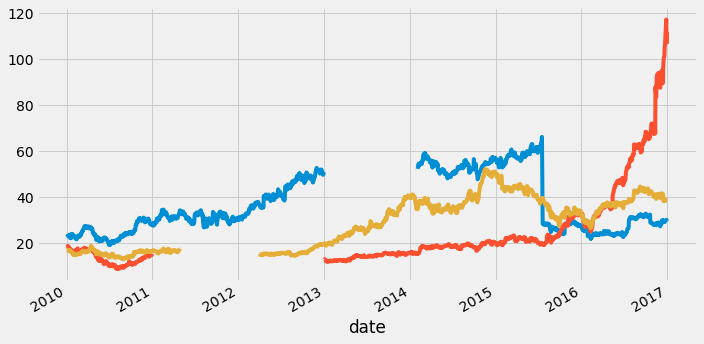

EBAY    273
NVDA    502
YHOO    232
dtype: int64


In [28]:
# Visualize the time series data using Pandas.
prices.plot(legend=False)
plt.tight_layout()
plt.show()

# Calculate the number of missing values in each time series. 
missing_values = prices.isna().sum()
print(missing_values)
#Note any irregularities that you can see. What do you think they are?
    
# Nice job. In the plot, you can see there are clearly missing chunks of time in your data. 
# There also seem to be a few 'jumps' in the data. How can you deal with this?    
      

#### 2 B Imputing missing values
When you have missing data points, how can you fill them in?

In this exercise, you'll practice using different interpolation methods to fill in some missing values, visualizing the result each time. But first, you will create the function `(interpolate_and_plot())` you'll use to interpolate missing data points and plot them.

A single time series has been loaded into a DataFrame called prices.

In [29]:
# Create a function we'll use to interpolate and plot
def interpolate_and_plot(prices, interpolation):

    # Create a boolean mask for missing values
    missing_values = prices.isna()

    # Interpolate the missing values
    prices_interp = prices.interpolate(interpolation)

    # Plot the results, highlighting the interpolated values in black
    fig, ax = plt.subplots(figsize=(10, 5))
    prices_interp.plot(color='k', alpha=.6, ax=ax, legend=False)
    
    # Now plot the interpolated values on top in red
    prices_interp[missing_values].plot(ax=ax, color='r', lw=3, legend=False)
    plt.show()

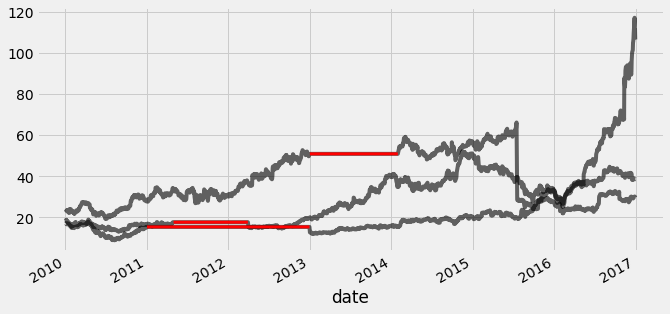

In [30]:
# Interpolate using the latest non-missing value and plot the results.
# Recall that interpolate_and_plot's second input is a string specifying the kind of interpolation to us
interpolation_type = "zero"
interpolate_and_plot(prices, interpolation_type)

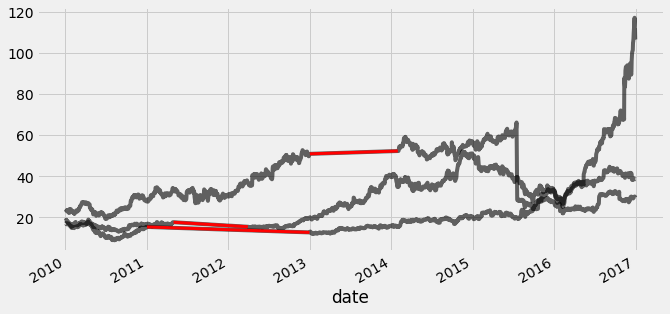

In [31]:
# Interpolate linearly
interpolation_type = "linear"
interpolate_and_plot(prices, interpolation_type)

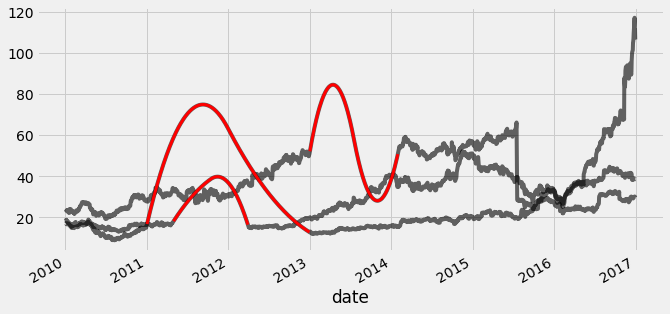

In [32]:
#Interpolate with a quadratic function and plot the results.
interpolation_type = "quadratic"
interpolate_and_plot(prices, interpolation_type)

note: Correct! When you interpolate, the pre-existing data is used to infer the values of missing data. As you can see, the method you use for this has a big effect on the outcome.

#### 2 C: Transforming raw data
In the last chapter, you calculated the rolling mean. In this exercise, you will define a function that calculates the percent change of the latest data point from the mean of a window of previous data points. This function will help you calculate the percent change over a rolling window.

This is a more stable kind of time series that is often useful in machine learning.

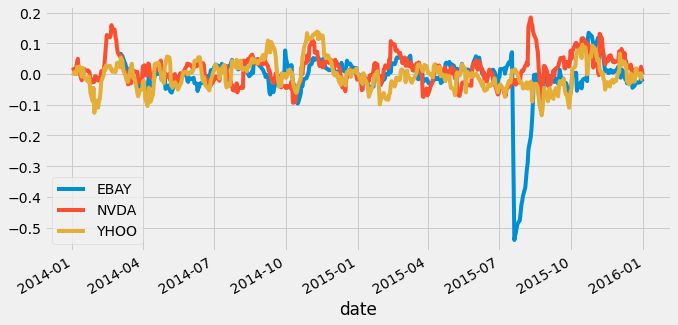

In [37]:
# Define a percent_change function that takes an input time series and does the following:
# Extract all but the last value of the input series (assigned to previous_values) and the only the last value of the timeseries ( assigned to last_value)
# Calculate the percentage difference between the last value and the mean of earlier values.

def percent_change(series):
    previous_values = series[:-1]
    last_value = series[-1]
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    
    return percent_change    

# Using a rolling window of 20, apply this function to prices, and visualize it using the given code.

prices_perc = prices.rolling(20).aggregate(percent_change)
prices_perc.loc["2014":"2015"].plot()
plt.show()

 note: Correct! You've converted the data so it's easier to compare one time point to another. This is a cleaner representation of the data.

#### 2 D Handling outliers
In this exercise, you'll handle outliers - data points that are so different from the rest of your data, that you treat them differently from other "normal-looking" data points. You'll use the output from the previous exercise (percent change over time) to detect the outliers. First you will write a function that replaces outlier data points with the median value from the entire time series.

 - Define a function that takes an input series and does the following:
 - Calculates the absolute value of each datapoint's distance from the series mean, then creates a boolean mask for datapoints that are three times the standard deviation from the mean.
 - Use this boolean mask to replace the outliers with the median of the entire series.
 - Apply this function to your data and visualize the results using the given code.

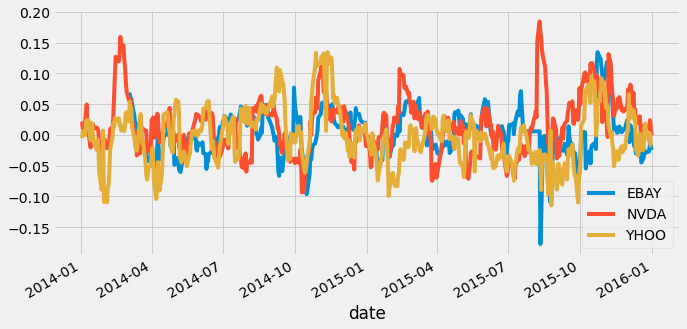

In [39]:
def replace_outliers(series):
    # Calculate the absolute difference of each timepoint from the series mean
    absolute_differences_from_mean = np.abs(series - np.mean(series))
    
    # Calculate a mask for the differences that are > 3 standard deviations from zero
    this_mask = absolute_differences_from_mean > (np.std(series) * 3)
    
    # Replace these values with the median accross the data
    series[this_mask] = np.nanmedian(series)
    return series

# Apply your preprocessing function to the timeseries and plot the results
prices_perc = prices_perc.apply(replace_outliers)
prices_perc.loc["2014":"2015"].plot()
plt.show()
    

note: Great job! Since you've converted the data to % change over time, it was easier to spot and correct the outliers.

### 3 Creating features over time
- Calculating "date-based" features
    - Thus far we've focused on calculating "statistical" features - these are features that correspond statistical properties of the data, like "mean" , "standard deviation", etc
    - However, don't forget the timeseries data oftenhas more "human" features associated with it, like days of the week, holidays, etc.
    - These features are often useful when dealing with timeseries data that spans multiple years (such as stock value over time)

#### 3 A: Engineering multiple rolling features at once
Now that you've practiced some simple feature engineering, let's move on to something more complex. You'll calculate a collection of features for your time series data and visualize what they look like over time. This process resembles how many other time series models operate.

 - Define a list consisting of four features you will calculate: the minimum, maximum, mean, and standard deviation (in that order).
 - Using the rolling window `(prices_perc_rolling)` we defined for you, calculate the features from `features_to_calculate`.
 - Plot the results over time, along with the original time series using the given code.

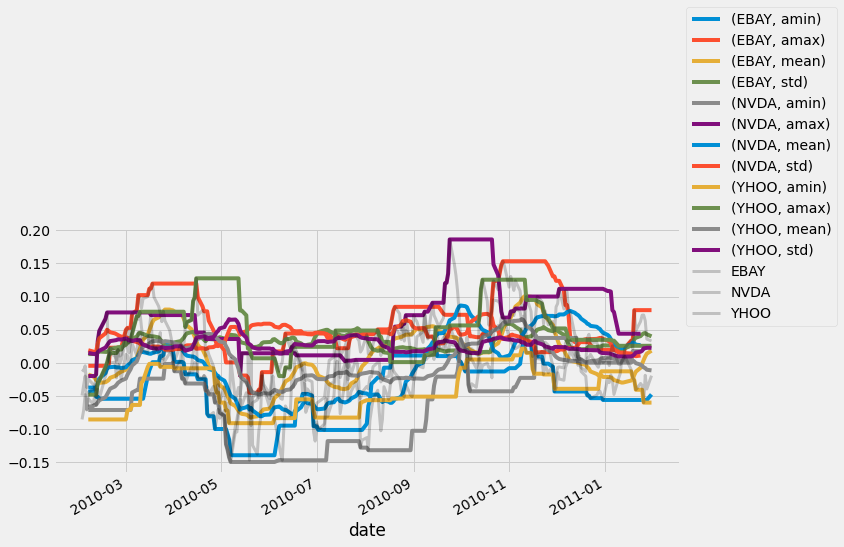

In [40]:
# Define a rolling window with Pandas, excluding the right-most datapoint of the window
prices_perc_rolling = prices_perc.rolling(20, min_periods=5, closed='right')

# Define the features you'll calculate for each window
features_to_calculate = [np.min, np.max, np.mean, np.std]

# Calculate these features for your rolling window object
features = prices_perc_rolling.aggregate(features_to_calculate)

# Plot the results
ax = features.loc[:"2011-01"].plot()
prices_perc.loc[:"2011-01"].plot(ax=ax, color='k', alpha=.2, lw=3)
ax.legend(loc=(1.01, .6))
plt.show()

#### 3 B: Percentiles and partial functions
In this exercise, you'll practice how to pre-choose arguments of a function so that you can pre-configure how it runs. You'll use this to calculate several percentiles of your data using the same percentile() function in numpy.

 - Import partial from functools.
 - Use the `partial()` function to create several feature generators that calculate percentiles of your data using a list comprehension.
 - Using the rolling window `(prices_perc_rolling)` we defined for you, calculate the quantiles using `percentile_functions`.
 - Visualize the results using the code given to you.

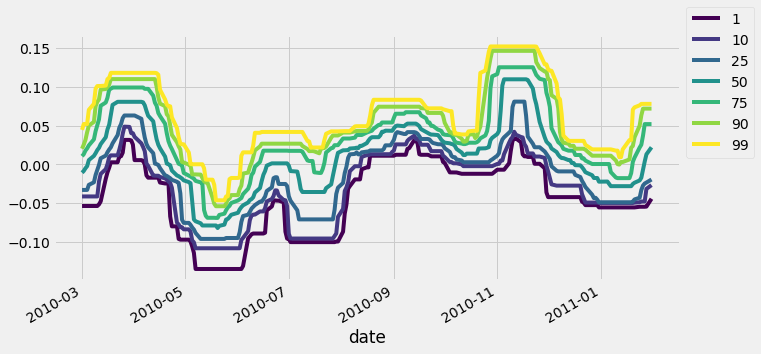

In [43]:
from functools import partial
percentiles = [1, 10, 25, 50, 75, 90, 99]
# Use a list comprehension to create a partial function for each quantile
percentile_functions = [partial(np.percentile, q=percentiles) for percentiles in percentiles]

# Calculate each of these quantiles on the data using a rolling window
prices_perc_rolling = prices_perc["EBAY"].rolling(20, min_periods=5, closed="right")
features_percentiles =  prices_perc_rolling.aggregate(percentile_functions)
# Plot a subset of the result
ax = features_percentiles.loc[:"2011-01"].plot(cmap=plt.cm.viridis);
ax.legend(percentiles, loc=(1.01, 0.5));

#### 3 C Using "date" information
It's easy to think of timestamps as pure numbers, but don't forget they generally correspond to things that happen in the real world. That means there's often extra information encoded in the data such as "is it a weekday?" or "is it a holiday?". This information is often useful in predicting timeseries data.

In this exercise, you'll extract these date/time based features. A single time series has been loaded in a variable called prices.

 - Calculate the day of the week, week number in a year, and month number in a year.
 - Add each one as a column to the `prices_perc` DataFrame, under the names `day_of_week`, `week_of_year` and `month_of_year`, respectively.

In [45]:
prices_perc["day_of_week"] = prices_perc.index.dayofweek
prices_perc["week_of_year"] = prices_perc.index.weekofyear
prices_perc["month_of_year"] = prices_perc.index.month
print(prices_perc)

                EBAY      NVDA      YHOO  day_of_week  week_of_year  \
date                                                                  
2010-01-04       NaN       NaN       NaN            0             1   
2010-01-05       NaN       NaN       NaN            1             1   
2010-01-06       NaN       NaN       NaN            2             1   
2010-01-07       NaN       NaN       NaN            3             1   
2010-01-08       NaN       NaN       NaN            4             1   
...              ...       ...       ...          ...           ...   
2016-12-23  0.024842  0.147720 -0.038006            4            51   
2016-12-27  0.038030  0.014446 -0.027985            1            52   
2016-12-28  0.026925  0.117737 -0.029311            2            52   
2016-12-29  0.021850  0.129669 -0.028632            3            52   
2016-12-30  0.007285  0.068559 -0.026603            4            52   

            month_of_year  
date                       
2010-01-04          